In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import pickle
import argparse
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
import sys
import datetime
from pathlib import Path
import seaborn as sns
import time
from Bio import SeqIO
from torch.utils.data import DataLoader
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from config import *
import util.misc as utils
from models.nt_classifier import build as build_model
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [3]:
MAX_N_GROUP_SIZE = 300

In [7]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2')#'binary_cl2')

# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') 

In [5]:
pairs = pd.read_csv(os.path.join('/data01/giorgio/RNARNA-NT/dataset/external_dataset/pulldown', 'pairs.txt'), header = None)
pairs = pairs[0].str.extractall('(.*)_(.*)').reset_index()
pairs = pairs.rename({0:'gene1', 1:'gene2'}, axis = 1)

embedding_dir = os.path.join('/data01/giorgio/RNARNA-NT/dataset/external_dataset/pulldown/embeddings/32')

In [8]:
device = torch.device(args.device)
model = build_model(args)
model.to(device)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.eval()

BinaryClassifierNT(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=256, bias=True)
    )
    (hidden_layers): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
    )
    (output_layer): Linear(in_features=256, out_features=256, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
      (1): ReLU()
    )
    (dropout_layers): ModuleList(
      (0-1): 2 x Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=

In [9]:
pos = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/pulldown/cand_99.ids.fa'
neg = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/pulldown/ctrl_99.ids.fa'

pairs_file = open('/data01/giorgio/RNARNA-NT/dataset/external_dataset/pulldown/pairs.txt', "a")

lhx_id = 'ENSMUST00000128121'

neg_genes = []
pos_genes = []

for fasta in SeqIO.parse(open(neg),'fasta'):
    name = str(fasta.description)
    neg_genes.append(name)

for fasta in SeqIO.parse(open(pos),'fasta'):
    name = str(fasta.description)
    pos_genes.append(name)

pairs_file.close()

In [13]:
probability = []
g1 = []
g2 = []
len_g1 = []
len_g2 = []
ids = []

for _, row in tqdm(pairs.iterrows(), total = pairs.shape[0]):
    gene1 = row.gene1
    gene2 = row.gene2
    
    rna1 = np.load(os.path.join(embedding_dir, gene1+'.npy'))
    rna2 = np.load(os.path.join(embedding_dir, gene2+'.npy'))
    
    rna1 = torch.tensor(rna1).unsqueeze(0).to(device)
    rna2 = torch.tensor(rna2).unsqueeze(0).to(device)
    
    rna1 = torch.transpose(rna1, 1, 2)
    rna2 = torch.transpose(rna2, 1, 2)
    
    outputs = model(rna1, rna2)
    probability += outputs.softmax(-1)[:, 1].tolist()
    
    g1.append(gene1)
    g2.append(gene2)
    len_g1.append(rna1.shape[2])
    len_g2.append(rna2.shape[2])
    ids.append(gene1 + '_' + gene2)

  0%|          | 0/312 [00:00<?, ?it/s]

In [14]:
res = pd.DataFrame({
    'id_sample':ids,
    'probability':probability,
    'g1':g1,
    'g2':g2,
    'len_g1': len_g1,
    'len_g2': len_g2,
})

In [15]:
res['ground_truth'] = 0
res.loc[res.g2.isin(pos_genes), "ground_truth"] = 1

res['prediction'] = res.probability>0.5

In [39]:
auc_values = []
acc_values = []

#sample res
for i in range(1500):
    subset_pos=res[res['ground_truth'] == 1]
    n_pos = subset_pos.shape[0]
    subset_neg = res[res['ground_truth'] == 0].sample(n_pos)
    subset = pd.concat([subset_pos, subset_neg], axis = 0)
    
    acc = subset[subset.prediction == subset.ground_truth].shape[0]/subset.shape[0]
    
    fpr, tpr, _ = roc_curve(subset.ground_truth, subset.probability)
    roc_auc = auc(fpr, tpr)
    
    auc_values.append(roc_auc)
    acc_values.append(acc)

In [40]:
np.mean(acc_values)

0.5233398692810457

In [41]:
np.mean(auc_values)

0.5191088043060361

In [42]:
print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80       261
           1       0.19      0.29      0.23        51

    accuracy                           0.68       312
   macro avg       0.52      0.52      0.51       312
weighted avg       0.74      0.68      0.70       312



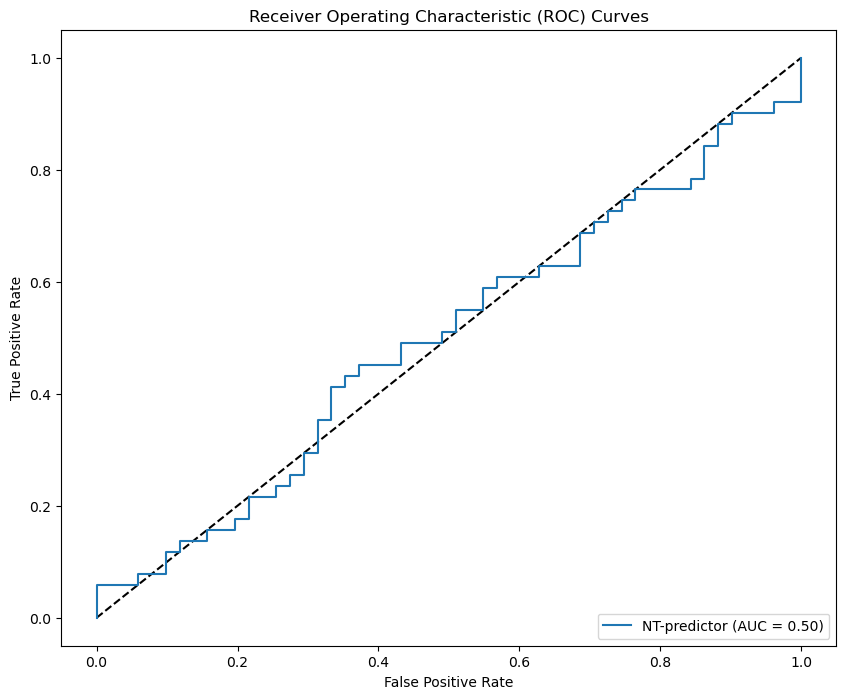

In [43]:
plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT-predictor'}], subset.ground_truth)

## Metrics

In [26]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

False    233
True      79
Name: prediction, dtype: int64


0    261
1     51
Name: ground_truth, dtype: int64


In [27]:
n_conf = 10

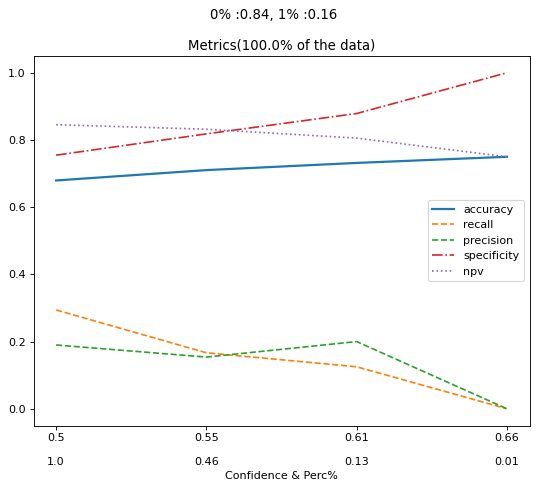

In [28]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)